In [1]:
%run utilities.ipynb


ValidationError: 1 validation error for SerpAPIWrapper
  Value error, Did not find serpapi_api_key, please add an environment variable `SERPAPI_API_KEY` which contains it, or pass `serpapi_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error

ValidationError: 1 validation error for SerpAPIWrapper
  Value error, Did not find serpapi_api_key, please add an environment variable `SERPAPI_API_KEY` which contains it, or pass `serpapi_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error

In [2]:
model= ChatOpenAI(model="gpt-3.5-turbo", temperature=0) 
wolfram_tool = load_tools(["wolfram-alpha"])
wolfram_node = ToolNode(tools=[*wolfram_tool])
model_with_tool = model.bind_tools(wolfram_tool)

In [3]:
class Prompt_Manager:

    def get_SYS_CREATE_PROMPT (self,expert):
        self.SYS_CREATE_PROMPT =f""" 
        You are an expert {expert} instructor.
        You are highly skilled at creating {expert} problems.
        """
        return self.SYS_CREATE_PROMPT

    def get_USER_CREATE_PROMPT(self,task,application):
           
        self.USER_CREATE_PROMPT =f""" 
        
        **Create a problem about "{task}" related to a application in {application}. Do not solve the problem.
        
        ### Follow the instructions below:
        
        1. **Problem Generation**:
           - Develop a math or science problem appropriate for a high school student, ensuring it is relevant to the provided task and application.
           - Use concrete numbers and details in the problem statement rather than abstract variables.
        
        2. **Problem Breakdown**:
           - Clearly explain the problem by breaking it down into understandable components.
           - Make sure the question is clearly defined, and highlight what the student is expected to solve.
           
        3. **Problem Meaning**:   
           - Clearly explain the meaning of each problem part in the given context.
           - Generate your response about the Problem Meaning based on the following example:
             ### Example ###
             Input: What is the meaning of the eigenvalues of a matrix in the context of a quantum mechanical measurement? 
             Output:
              - In quantum mechanics, the meaning of the matrix elements correspond to the transition amplitudes from one state into another.
              - The meaning of eigenvalues of a matrix representing an observable correspond to the possible measurable outcomes of 
             that observable.When a measurement is made, the system collapses to an eigenstate associated with one of these eigenvalues, 
             which is then observed as the measurement result.
             Continue until each part of the problem is explained.
        
      """
        return self.USER_CREATE_PROMPT

    def get_SOLVE_PROMPT (self,problem):
        self.SOLVE_PROMPT =f""" 

        Use the provided Wolram Tool to solve the Problem:
        {problem}
        
        ### Follow the instructions below:
            
        1. **Step-by-Step Solution**:
           - Provide a detailed, step-by-step solution to the problem, ensuring clarity at each stage.
           - Explain each step thoroughly to make the reasoning easy to follow and ensure that each part of the process is justified.
        
        2. **Solution Review**:
           - Explain in detail the meaning of the solution in the given context.
        
        """
        return self.SOLVE_PROMPT
        




In [4]:
def llm_call(sys_prompt, user_prompt, gpt_model):
    print("gpt_model",gpt_model)
    if gpt_model == "gpt3":  
        model= ChatOpenAI(model="gpt-3.5-turbo", temperature=0) 
        messages = [
            SystemMessage(content=sys_prompt), 
            HumanMessage(content=user_prompt)  
        ]
        response = model.invoke(messages).content
    elif gpt_model == "gpt4": 
        model= ChatOpenAI(model="gpt-4o", temperature=0) 
        messages = [
            SystemMessage(content=sys_prompt), 
            HumanMessage(content=user_prompt)  
        ]
        response = model.invoke(messages).content

    elif gpt_model == "gemini_pro": 
        model = genai.GenerativeModel('gemini-1.5-pro-latest',system_instruction=sys_prompt)
        response = model.generate_content(user_prompt).text  
        
    elif gpt_model == "gemini_flash": 
        model = genai.GenerativeModel('gemini-1.5-flash-latest',system_instruction=sys_prompt)
        response = model.generate_content(user_prompt).text  
        
    elif gpt_model =="llama":    
        response = llama.run(user_prompt)
        response=json.dumps(response.json(), indent=2)
    return response

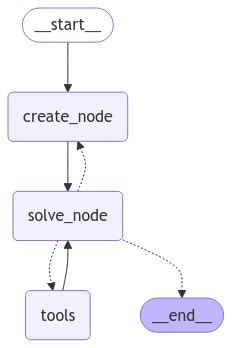

In [5]:
class Math_Agent:
    def __init__(self,gpt_model):
        self.prompt_manager=Prompt_Manager()    
        self.gpt_model=gpt_model
        
    class State(TypedDict):
        expert:str
        task:str
        application:str
        problem:str
        messages: Annotated[list, add_messages]
        
    def create_node(self,state:'Math_Agent.State'):
        print("Start_node")
        sys_prompt = self.prompt_manager.get_SYS_CREATE_PROMPT(state["expert"])
        user_prompt = self.prompt_manager.get_USER_CREATE_PROMPT(state["task"],state["application"])
        response=llm_call( sys_prompt, user_prompt, self.gpt_model)       
        prompt=self.prompt_manager.get_SOLVE_PROMPT(response)
   
        return {"problem": response,"messages": prompt}

    def solve_node(self,state:'Math_Agent.State'):
       
        return {"messages": [model_with_tool.invoke(state["messages"])]}
    

    def init_graph(self):
       
        graph_builder = StateGraph(Math_Agent.State)
    
        graph_builder.add_node("create_node",self.create_node)
        graph_builder.add_node("solve_node",self.solve_node)        
        tool_node=wolfram_node
        graph_builder.add_node("tools", tool_node)
        
        graph_builder.add_conditional_edges(
            "solve_node",
            tools_condition,
#            {"action": "tools", "__end__": END}
        )
        graph_builder.add_edge("create_node", "solve_node")
        graph_builder.add_edge("tools", "solve_node")

        graph_builder.set_entry_point("create_node")
        graph = graph_builder.compile()#checkpointer=memory1)
        return graph

    def run_graph(self,state,graph):   
        print("run_graph")
        thread = {"configurable": {"thread_id": "1"}}
        state = graph.invoke(state, thread)
        return state    

math_agent=Math_Agent("gpt3")        
graph=math_agent.init_graph()
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
state=math_agent.State()
state["task"]="Integrals."
state["application"]="Economics"
state["expert"]="Math"
#state=math_agent.run_graph(state,graph)

In [7]:
#for st in state["messages"]:
#    display("st: ",st)

In [8]:
#for st in state["messages"]:
#    display("st: ",st.content)

In [9]:
#state["messages"][-1].content

In [13]:
class Math_Creator():
    def __init__(self):
        self.format=Formatting()
        
    def init_agent(self,gpt_model):
        print("Human Problem Solver init_agent")
        self.agent = Math_Agent(gpt_model)
        self.graph = self.agent.init_graph()
        self.state=self.agent.State()
        self.model=gpt_model
       

    def Run_Agent(self,expert,task,application):
        print("Math Creator Run_agent",expert,task,application)
        if not expert:
            return pn.WidgetBox(pn.Row('Problem Solver:', pn.pane.Markdown("", width=600)), scroll=True)
        self.state["expert"]=expert
        self.state["task"]=task
        self.state["application"]=application
        self.state=self.agent.run_graph(self.state,self.graph)       
        self.answer=self.state["problem"]+self.state["messages"][-1].content
        output=self.answer   
        return output

    def Latex(self,key):
        print("Latex",key) 
        if key=="Yes":
            Latex=self.format.Latex_Formatting(self.model,"",self.answer) 
            self.Save_File(Latex,self.answer,"MathProblem")
      
    
    def translate(self,key): 
        print("translation",key)
        if key=="German":
            output=translator.translate_text(self.answer, target_lang="DE").text  
            Latex=self.format.Latex_Formatting(self.model,"",output) 
            
            self.Save_File(Latex,output,"DEMathProblem")
            return output
        else:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No Translation")), width=600, scroll=True)
            
    def Save_File(self,inp1,inp2,name:str): 
         
        file_path = fr".\outputfiles\{name}.tex"
        with open(file_path, "w",encoding="utf-8") as file:
            file.write(inp1)       
        file_path = fr".\outputfiles\{name}.html"
        markdown=pn.pane.Markdown(inp2)
        markdown.save(file_path)



In [14]:
app = Math_Creator()
app.init_agent("gpt3")
expert="Math"
task="integrals"
application="Economy"
#out=app.Run_Agent(expert,task,application)

Human Problem Solver init_agent


In [15]:
class Math_APP:
    def __init__(self):
        # Initialize the Problem Creator App
        self.app = Math_Creator()
        
        # Initialize widgets and UI elements
        self.description = pn.pane.Markdown("Create a problem about 'task' related to a world application in 'application", height=50, width=600)
        self.gpt = pn.widgets.Select(name='Which gpt model', options=['gpt3', 'gpt4', 'gemini_flash', 'gemini_pro'], width=100)
        self.init_agent = pn.bind(self.app.init_agent, self.gpt)
        self.language = pn.widgets.Select(name='Language Options', options=['German'], width=100)
        
        self.task = pn.widgets.TextInput(name="What task shall I perform, for example Matrices and determinants:", placeholder="Enter the task", sizing_mode="stretch_width")
        self.expert = pn.widgets.Select(name='Expert in', options=['Math', 'Physics'], width=100)
        self.application = pn.widgets.TextInput(name='Specify an application: for example apply to economics', placeholder='', sizing_mode="stretch_width")
        self.Latex = pn.widgets.Select(name='Create english Latex file', options=['Yes','No'], width=200)

        # Define buttons and output panes
        self.start_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)
        self.output1 = pn.pane.Markdown("Answer")

        self.translation_button = pn.widgets.Button(name="Translation", button_type="primary", width=50, height=50)
        self.output4 = pn.pane.Markdown("Translation")

        self.Latex_button = pn.widgets.Button(name="Latex", button_type="primary", width=50, height=50)
        self.outlatex = pn.pane.Markdown("Latex")

        # Attach button click event handlers
        self.start_button.on_click(self.start_button_click)
        self.translation_button.on_click(self.translation_button_click)
        self.Latex_button.on_click(self.Latex_button_click)


    def start_button_click(self, event):
        if self.start_button.clicks > 0:
            bound_function = pn.bind(self.app.Run_Agent, self.expert.value, self.task.value, self.application.value)
            try:
                result = bound_function()
                self.output1.object = f"Start answer:\n {result}"
            except Exception as e:
                self.output1.object = f"Error in start_button_click: {e}"

    def translation_button_click(self, event):
        if self.translation_button.clicks > 0:
            bound_function = pn.bind(self.app.translate, self.language.value)
            try:
                result = bound_function()
                self.output4.object = f"Translation:\n {result}"
            except Exception as e:
                self.output4.object = f"Error in translation_button_click: {e}"

    def Latex_button_click(self, event):
        if self.Latex_button.clicks > 0:
            bound_function = pn.bind(self.app.Latex, self.Latex.value)
            try:
                result = bound_function()
                self.outlatex.object = f"Latex:\n {result}"
            except Exception as e:
                self.outlatex.object = f"Error in Latex_button_click: {e}"

    def create_layout(self):
        # Create the main layout
        translation = pn.Column(
            pn.Row(self.Latex, pn.panel(self.Latex_button, loading_indicator=True)),
            pn.Row(self.language,pn.panel(self.translation_button, loading_indicator=True)),
            pn.layout.Divider(),
            pn.panel(self.output4, loading_indicator=True, height=900),
        )
        

        column1 = pn.Column(
            self.description,
            self.init_agent,
            pn.Row(self.gpt, self.expert),
            pn.Row(self.task),
            pn.Row(self.application),
            pn.panel(self.start_button, loading_indicator=True, height=50),
            pn.layout.Divider(),
            pn.panel(self.output1, loading_indicator=True, height=900),
            sizing_mode="stretch_width"
        )

        PC = pn.Column(
            pn.Row(column1, sizing_mode="stretch_width")
        )

        Tabs=[PC,translation]
        return Tabs

app = Math_APP()
Tabs=app.create_layout()
layout = pn.Column(
                   pn.Tabs(
                          ('HPS',Tabs[0]),('Latex and Translation',Tabs[1])
                   ))
    
layout.show()

Human Problem Solver init_agent
Launching server at http://localhost:53263
Math Creator Run_agent Math differential equations quatum mechanics
run_graph
Start_node
gpt_model gpt3
Latex Yes
Latex,model gpt4
gpt_model gpt4
translation German
Latex,model gpt4
gpt_model gpt4
